In [2]:
import time
import numpy as np
import pandas as pd
import shogun as sg
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def saveInfo(name, my_time, my_acc, my_F1, my_precision, my_recall, timeDict, accDict, F1Dict, precisionDict, recallDict):
	timeDict[name] = my_time
	accDict[name] = my_acc
	F1Dict[name]= my_F1
	precisionDict[name] = my_precision
	recallDict[name] = my_recall
	# print("---{}: {} seconds ---".format (name, my_time))
	# print('{}, {} accuracy score: {}, F1-score: {}'.format(title, name, accuracy_score, my_F1))

def evaluateAndSave(name, train_time, features_test, labels_test, labels_predict, timeDict, accDict, F1Dict, precisionDict, recallDict):
	acc = sg.AccuracyMeasure().evaluate(labels_predict, labels_test)
	f1 = sg.F1Measure().evaluate(labels_predict, labels_test)
	prec = sg.PrecisionMeasure().evaluate(labels_predict, labels_test)
	rec = sg.RecallMeasure().evaluate(labels_predict, labels_test)
	print('Accuracy:', acc)
	print('F1:', f1)
	print('Precision:', prec)
	print('Recall:', rec)
	saveInfo(name, train_time, acc, f1, prec, rec, timeDict, accDict, F1Dict, precisionDict, recallDict)

train_data_source = './exercise_data/human_dna_train_split_5_95.csv'
test_data_source = './exercise_data/human_dna_test_split.csv'

train_df = pd.read_csv(train_data_source, header=0)
test_df = pd.read_csv(test_data_source, header=0)

train_seq = train_df['sequences']
train_label = train_df['labels']
test_seq = test_df['sequences']
test_label = test_df['labels']

train_seq = np.array(train_seq)
train_label = np.array(train_label)
test_seq = np.array(test_seq)
test_label = np.array(test_label)

print('train_seq shape:', train_seq.shape)
print('test_seq shape:', test_seq.shape)

timeDict = {}
accDict = {}
F1Dict = {}
precisionDict = {}
recallDict = {}

features_train = sg.StringCharFeatures(train_seq.tolist(), sg.DNA)
features_test = sg.StringCharFeatures(test_seq.tolist(), sg.DNA)
labels_train = sg.BinaryLabels(np.array(train_label))
labels_test = sg.BinaryLabels(np.array(test_label))

# SVM
C = 1.0
epsilon = 0.001

train_seq shape: (29420,)
test_seq shape: (33333,)


### Weighted Degree Kernel

In [2]:
svm = sg.LibSVM(C, sg.WeightedDegreeStringKernel(features_train, features_train, 5), labels_train)
svm.set_epsilon(epsilon)
start = time.time()
svm.train()
evaluateAndSave("WeightedDegreeStringKernel", time.time()-start, 
				features_test, labels_test, svm.apply_binary(features_test),
				timeDict, accDict, F1Dict, precisionDict, recallDict)

Accuracy: 0.996189961899619
F1: 0.2111801242236025
Precision: 0.2982456140350877
Recall: 0.16346153846153846


##### Hyperparameter Search

degrees [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Cs [1.00000000e-03 5.27263158e-01 1.05352632e+00 1.57978947e+00
 2.10605263e+00 2.63231579e+00 3.15857895e+00 3.68484211e+00
 4.21110526e+00 4.73736842e+00 5.26363158e+00 5.78989474e+00
 6.31615789e+00 6.84242105e+00 7.36868421e+00 7.89494737e+00
 8.42121053e+00 8.94747368e+00 9.47373684e+00 1.00000000e+01]
degree 1
C 0.001
C 0.5272631578947369
C 1.0535263157894736
C 1.5797894736842104
C 2.1060526315789474
C 2.6323157894736844
C 3.158578947368421
C 3.684842105263158
C 4.211105263157895
C 4.737368421052632
C 5.263631578947369
C 5.789894736842106
C 6.316157894736842
C 6.84242105263158
C 7.368684210526316
C 7.894947368421054
C 8.42121052631579
C 8.947473684210527
C 9.473736842105263
C 10.0
degree 2
C 0.001
C 0.5272631578947369
C 1.0535263157894736
C 1.5797894736842104
C 2.1060526315789474
C 2.6323157894736844
C 3.158578947368421
C 3.684842105263158
C 4.211105263157895
C 4.737368421052632
C 5.263631578947369
C 5.789894736842106
C 6.316157894736842
C 

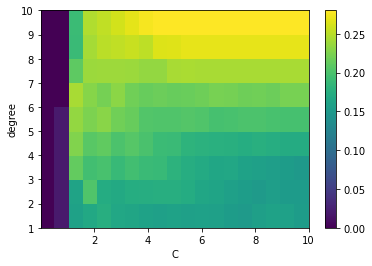

In [3]:
# Cs=[x for x in np.linspace(0.001,10,1)]
Cs=np.linspace(0.001,10,20)
degrees=[1,2,3,4,5,6,7,8,9,10]

print("degrees", degrees)
print("Cs", Cs)

results = np.zeros((len(degrees), len(Cs)))

for i in range(len(degrees)):
    print("degree", degrees[i])
    degree = degrees[i]
    
    for j in range(len(Cs)):
        print("C", Cs[j])
        svm = sg.LibSVM(Cs[j], sg.WeightedDegreeStringKernel(features_train, features_train, degree), labels_train)
        svm.set_epsilon(epsilon)
        start = time.time()
        svm.train()
        f1 = sg.F1Measure().evaluate(svm.apply_binary(features_test), labels_test)
        results[i,j]=f1

plt.pcolor(np.asarray(Cs), np.asarray(degrees), results)
plt.xlabel("C")
plt.ylabel("degree")
_=plt.colorbar()

### Weighted Degree Position Kernel

In [4]:
svm = sg.LibSVM(C, sg.WeightedDegreePositionStringKernel(features_train, features_train, 20), labels_train)
svm.set_epsilon(epsilon)
svm.set_batch_computation_enabled(True)
start = time.time()
svm.train()
evaluateAndSave("WeightedDegreePositionStringKernel", time.time()-start, 
				features_test, labels_test, svm.apply_binary(features_test),
				timeDict, accDict, F1Dict, precisionDict, recallDict)

Accuracy: 0.996819968199682
F1: 0.07017543859649122
Precision: 0.4
Recall: 0.038461538461538464


##### Hyperparameter Search

degrees [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Cs [1.00000000e-03 5.27263158e-01 1.05352632e+00 1.57978947e+00
 2.10605263e+00 2.63231579e+00 3.15857895e+00 3.68484211e+00
 4.21110526e+00 4.73736842e+00 5.26363158e+00 5.78989474e+00
 6.31615789e+00 6.84242105e+00 7.36868421e+00 7.89494737e+00
 8.42121053e+00 8.94747368e+00 9.47373684e+00 1.00000000e+01]
degree 1
C 0.001
C 0.5272631578947369
C 1.0535263157894736
C 1.5797894736842104
C 2.1060526315789474
C 2.6323157894736844
C 3.158578947368421
C 3.684842105263158
C 4.211105263157895
C 4.737368421052632
C 5.263631578947369
C 5.789894736842106
C 6.316157894736842
C 6.84242105263158
C 7.368684210526316
C 7.894947368421054
C 8.42121052631579
C 8.947473684210527
C 9.473736842105263
C 10.0
degree 2
C 0.001
C 0.5272631578947369
C 1.0535263157894736
C 1.5797894736842104
C 2.1060526315789474
C 2.6323157894736844
C 3.158578947368421
C 3.684842105263158
C 4.211105263157895
C 4.737368421052632
C 5.263631578947369
C 5.789894736842106
C 6.316157894736842
C 

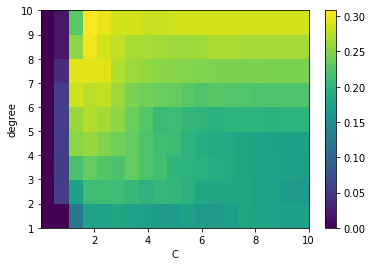

In [5]:
# Cs=[x for x in np.linspace(0.001,10,1)]
Cs=np.linspace(0.001,10,20)
degrees=[1,2,3,4,5,6,7,8,9,10]

print("degrees", degrees)
print("Cs", Cs)

results = np.zeros((len(degrees), len(Cs)))

for i in range(len(degrees)):
    print("degree", degrees[i])
    degree = degrees[i]
    
    for j in range(len(Cs)):
        print("C", Cs[j])
        svm = sg.LibSVM(Cs[j], sg.WeightedDegreePositionStringKernel(features_train, features_train, degree), labels_train)
        svm.set_epsilon(epsilon)
        start = time.time()
        svm.train()
        f1 = sg.F1Measure().evaluate(svm.apply_binary(features_test), labels_test)
        results[i,j]=f1
        
plt.pcolor(np.asarray(Cs), np.asarray(degrees), results)
plt.xlabel("C")
plt.ylabel("degree")
_=plt.colorbar()

##### Hyperparameter Search for Weighted Degree Kernel

degrees [8, 9, 10, 11, 12, 13, 14, 15]
Cs [ 8.          8.5862069   9.17241379  9.75862069 10.34482759 10.93103448
 11.51724138 12.10344828 12.68965517 13.27586207 13.86206897 14.44827586
 15.03448276 15.62068966 16.20689655 16.79310345 17.37931034 17.96551724
 18.55172414 19.13793103 19.72413793 20.31034483 20.89655172 21.48275862
 22.06896552 22.65517241 23.24137931 23.82758621 24.4137931  25.        ]
degree 8
C 8.0
C 8.586206896551724
C 9.172413793103448
C 9.758620689655173
C 10.344827586206897
C 10.931034482758621
C 11.517241379310345
C 12.103448275862068
C 12.689655172413794
C 13.275862068965516
C 13.862068965517242
C 14.448275862068964
C 15.034482758620689
C 15.620689655172413
C 16.206896551724135
C 16.79310344827586
C 17.379310344827587
C 17.96551724137931
C 18.551724137931032
C 19.137931034482758
C 19.724137931034484
C 20.310344827586206
C 20.89655172413793
C 21.482758620689655
C 22.068965517241377
C 22.655172413793103
C 23.241379310344826
C 23.827586206896548
C 24.41379310344

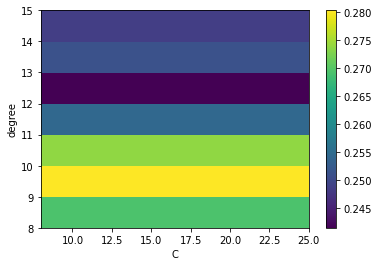

In [3]:
# Cs=[x for x in np.linspace(0.001,10,1)]
Cs=np.linspace(8,25,30)
degrees=[8,9,10,11,12,13,14,15]

print("degrees", degrees)
print("Cs", Cs)

results = np.zeros((len(degrees), len(Cs)))

for i in range(len(degrees)):
    print("degree", degrees[i])
    degree = degrees[i]
    
    for j in range(len(Cs)):
        print("C", Cs[j])
        svm = sg.LibSVM(Cs[j], sg.WeightedDegreeStringKernel(features_train, features_train, degree), labels_train)
        svm.set_epsilon(epsilon)
        start = time.time()
        svm.train()
        f1 = sg.F1Measure().evaluate(svm.apply_binary(features_test), labels_test)
        results[i,j]=f1

plt.pcolor(np.asarray(Cs), np.asarray(degrees), results)
plt.xlabel("C")
plt.ylabel("degree")
_=plt.colorbar()

In [4]:
results

array([[0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027,
        0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027,
        0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027,
        0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027,
        0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027,
        0.26936027, 0.26936027, 0.26936027, 0.26936027, 0.26936027],
       [0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303,
        0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303,
        0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303,
        0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303,
        0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303,
        0.28030303, 0.28030303, 0.28030303, 0.28030303, 0.28030303],
       [0.27385892, 0.27385892, 0.27385892, 0.27385892, 0.27385892,
        0.27385892, 0.27385892, 0.27385892, 0.27385892, 0.27385892,
        0.27385892, 0.27385892, 0.27385892, 0.